-------------
### ライブラリのインポート

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# タイピングのサポート
from typing import Optional

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

--------------
### 辞書作成

各ファイルからコピペする

In [2]:
TARGET = "GMV"
SAMPLE_SIZE = 100

if TARGET == "GMV":
    X_LIM_MAX = 300000
if TARGET == "BCR":
    X_LIM_MAX = 0.003


# ここからコピペ
# ランダムの分散(var_random)
var_random_train = 238051.96263906235
var_random_test = 238508.6545548929


# 別々に最適化の辞書(var_sep_dict)
var_sep_dict_train = {
    "Kmeans": {
        "Proportional": 236031.2464654796,
        "Post": 238212.92331078762,
        "Optimal": 219944.8350425424,
    },
    "Lasso-Kmeans": {
        "Proportional": 221117.76153311858,
        "Post": 214753.26328847185,
        "Optimal": 194801.4672319542,
    },
    "SFS-Kmeans-F": {
        "Proportional": 234256.9148222616,
        "Post": 237479.14860281156,
        "Optimal": 226155.70482623845,
    },
    "SFS-Kmeans-T": {
        "Proportional": 205633.48693857275,
        "Post": 228045.54794106635,
        "Optimal": 187563.38432431896,
    },
}
var_sep_dict_test = {
    "Kmeans": {
        "Proportional": 237453.55008812083,
        "Post": 239864.8394096634,
        "Optimal": 218761.3345468703,
    },
    "Lasso-Kmeans": {
        "Proportional": 228140.33206000947,
        "Post": 216067.1926522688,
        "Optimal": 195898.2087180184,
    },
    "SFS-Kmeans-F": {
        "Proportional": 232558.5004616108,
        "Post": 241931.75830047025,
        "Optimal": 224216.55669443565,
    },
    "SFS-Kmeans-T": {
        "Proportional": 215856.64125711913,
        "Post": 228232.0366777286,
        "Optimal": 185373.31888656615,
    },
}

# SFS-Kmeans-Var (var_once_dict)
var_once_dict_train = {
    "Proportional": 211051.5026894557,
    "Post": 207015.05990927195,
    "Optimal": 184999.06534810743,
}
var_once_dict_test = {
    "Proportional": 221235.43659239635,
    "Post": 211880.3385958233,
    "Optimal": 189471.23880255895,
}

# CUPED (var_cuped)
var_cuped_train = 207956.46307527836
var_cuped_test = 203497.55904269795

# COSS (var_coss)
var_coss_train = 207956.46307527836
var_coss_test = 203497.55904269795

分散削減率の計算

In [3]:
reduc_sep_dict_train = {}
reduc_sep_dict_test = {}
for method, d in var_sep_dict_train.items():
    reduc_sep_dict_train[method] = {}
    for allo, var in d.items():
        reduc_sep_dict_train[method][allo] = (1 - var / var_random_train) * 100
for method, d in var_sep_dict_test.items():
    reduc_sep_dict_test[method] = {}
    for allo, var in d.items():
        reduc_sep_dict_test[method][allo] = (1 - var / var_random_test) * 100

reduc_once_dict_train = {}
reduc_once_dict_test = {}
for allo, var in var_once_dict_train.items():
    reduc_once_dict_train[allo] = (1 - var / var_random_train) * 100
for allo, var in var_once_dict_test.items():
    reduc_once_dict_test[allo] = (1 - var / var_random_test) * 100

reduc_cuped_train = (1 - var_cuped_train / var_random_train) * 100
reduc_cuped_test = (1 - var_cuped_test / var_random_test) * 100

reduc_coss_train = (1 - var_coss_train / var_random_train) * 100
reduc_coss_test = (1 - var_coss_test / var_random_test) * 100

In [4]:
def make_var_dict(
    var_random: float,
    var_cuped: float,
    var_coss: float,
    var_sep_dict: dict[str, dict[str, float]],
    var_once_dict: dict[str, float],
) -> dict:
    var_dict = {"Random": var_random, "CUPED": var_cuped, "COSS": var_coss}
    for method, _ in var_sep_dict.items():
        var_dict[method] = {
            "Optimal": var_sep_dict[method]["Optimal"],
            "Post": var_sep_dict[method]["Post"],
            "Proportional": var_sep_dict[method]["Proportional"],
        }
    var_dict["SFS-Kmeans-Var"] = {
        "Optimal": var_once_dict["Optimal"],
        "Post": var_once_dict["Post"],
        "Proportional": var_once_dict["Proportional"],
    }

    return var_dict


def make_reduc_dict(
    reduc_cuped: float,
    reduc_coss: float,
    reduc_sep_dict: dict[str, dict[str, float]],
    reduc_once_dict: dict[str, float],
) -> dict:
    reduc_dict = {"CUPED": reduc_cuped, "COSS": reduc_coss}
    for method, _ in reduc_sep_dict.items():
        reduc_dict[method] = {
            "Optimal": reduc_sep_dict[method]["Optimal"],
            "Post": reduc_sep_dict[method]["Post"],
            "Proportional": reduc_sep_dict[method]["Proportional"],
        }
    reduc_dict["SFS-Kmeans-Var"] = {
        "Optimal": reduc_once_dict["Optimal"],
        "Post": reduc_once_dict["Post"],
        "Proportional": reduc_once_dict["Proportional"],
    }

    return reduc_dict

In [5]:
var_dict_train = make_var_dict(
    var_random=var_random_train,
    var_cuped=var_cuped_train,
    var_coss=var_coss_train,
    var_sep_dict=var_sep_dict_train,
    var_once_dict=var_once_dict_train,
)
var_dict_test = make_var_dict(
    var_random=var_random_test,
    var_cuped=var_cuped_test,
    var_coss=var_coss_train,
    var_sep_dict=var_sep_dict_test,
    var_once_dict=var_once_dict_test,
)

reduc_dict_train = make_reduc_dict(
    reduc_cuped=reduc_cuped_train,
    reduc_coss=reduc_coss_train,
    reduc_sep_dict=reduc_sep_dict_train,
    reduc_once_dict=reduc_once_dict_train,
)
reduc_dict_test = make_reduc_dict(
    reduc_cuped=reduc_cuped_test,
    reduc_coss=reduc_coss_test,
    reduc_sep_dict=reduc_sep_dict_test,
    reduc_once_dict=reduc_once_dict_test,
)

-----------
### 可視化

分散

訓練データの結果


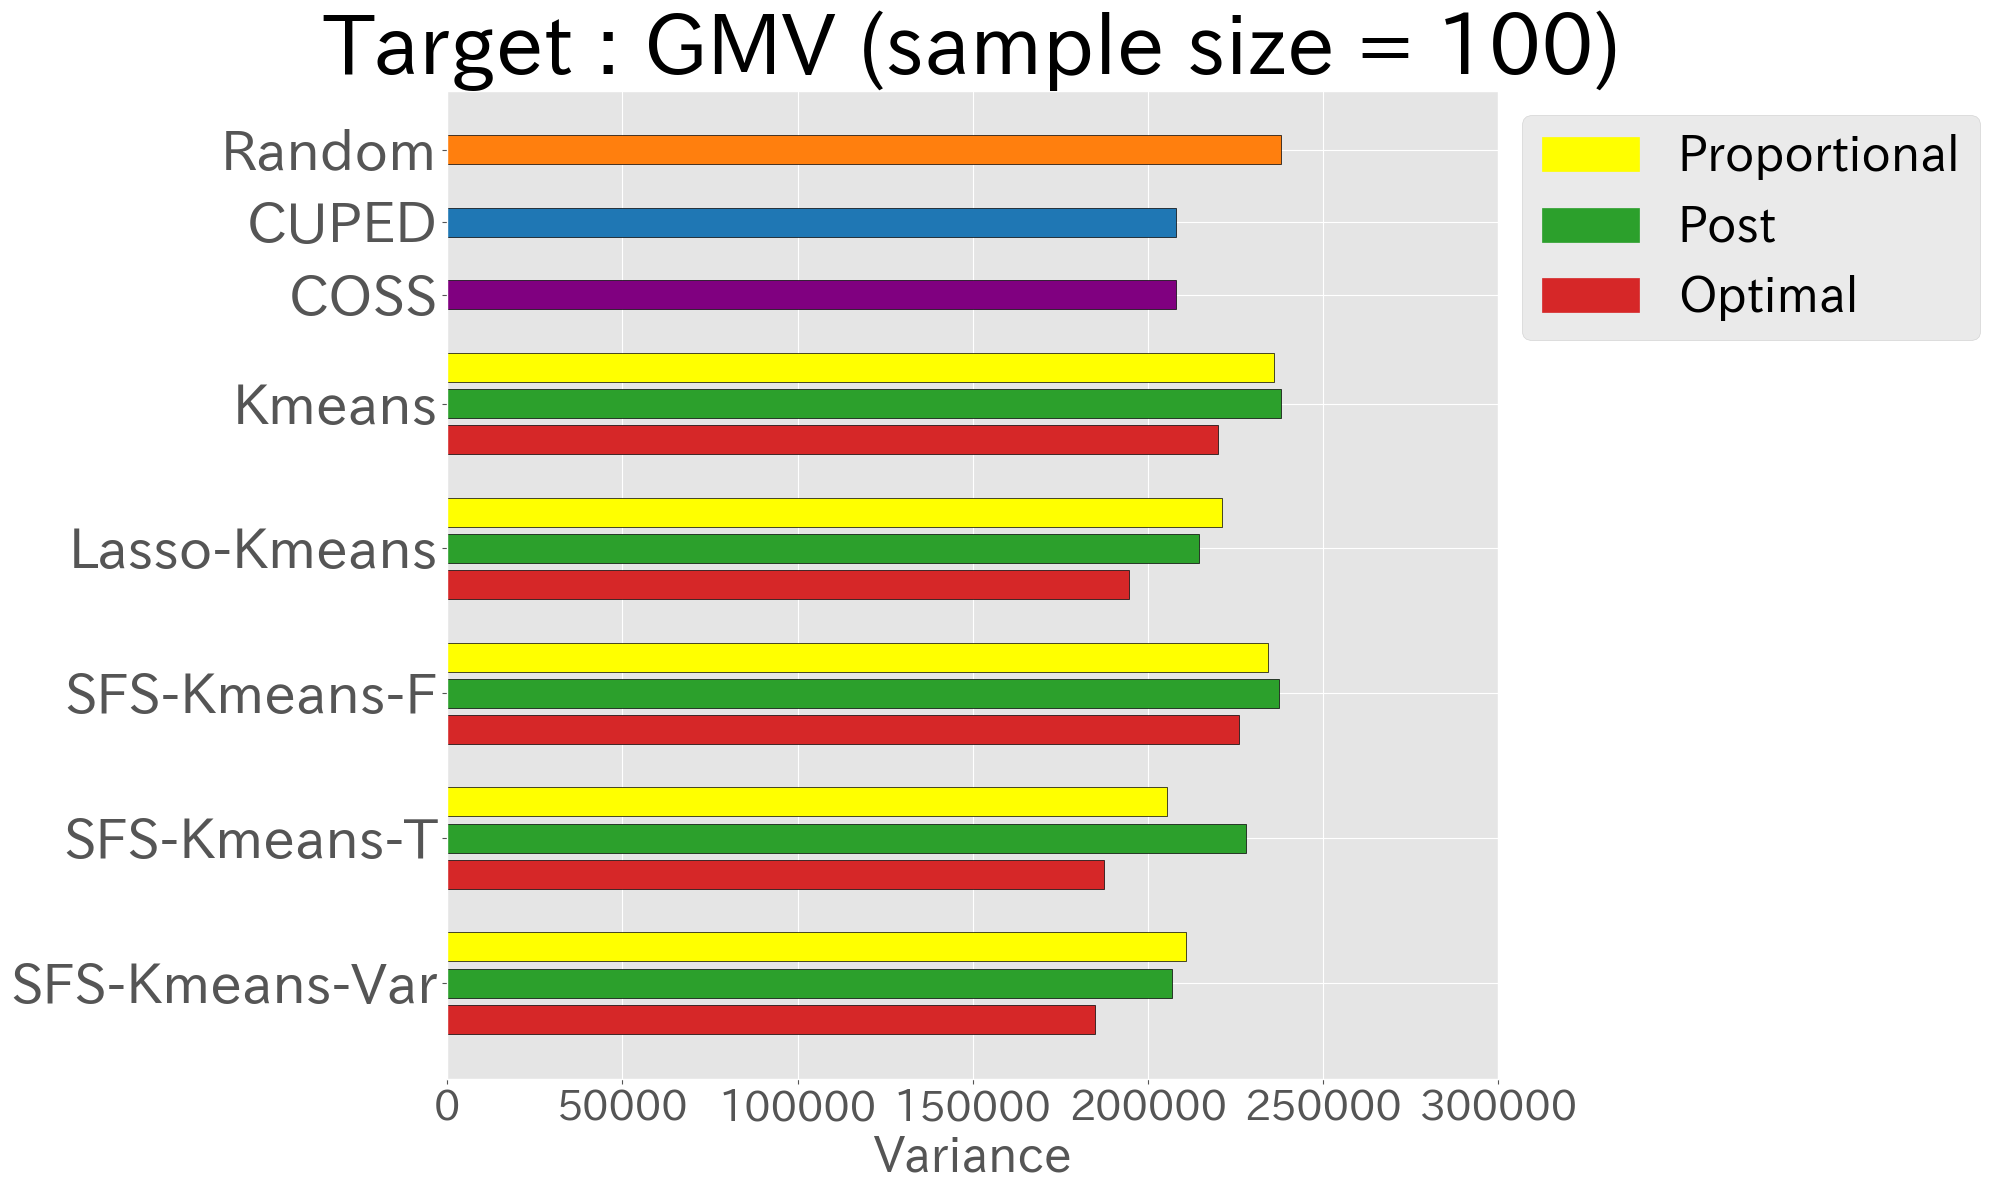

テストデータの結果


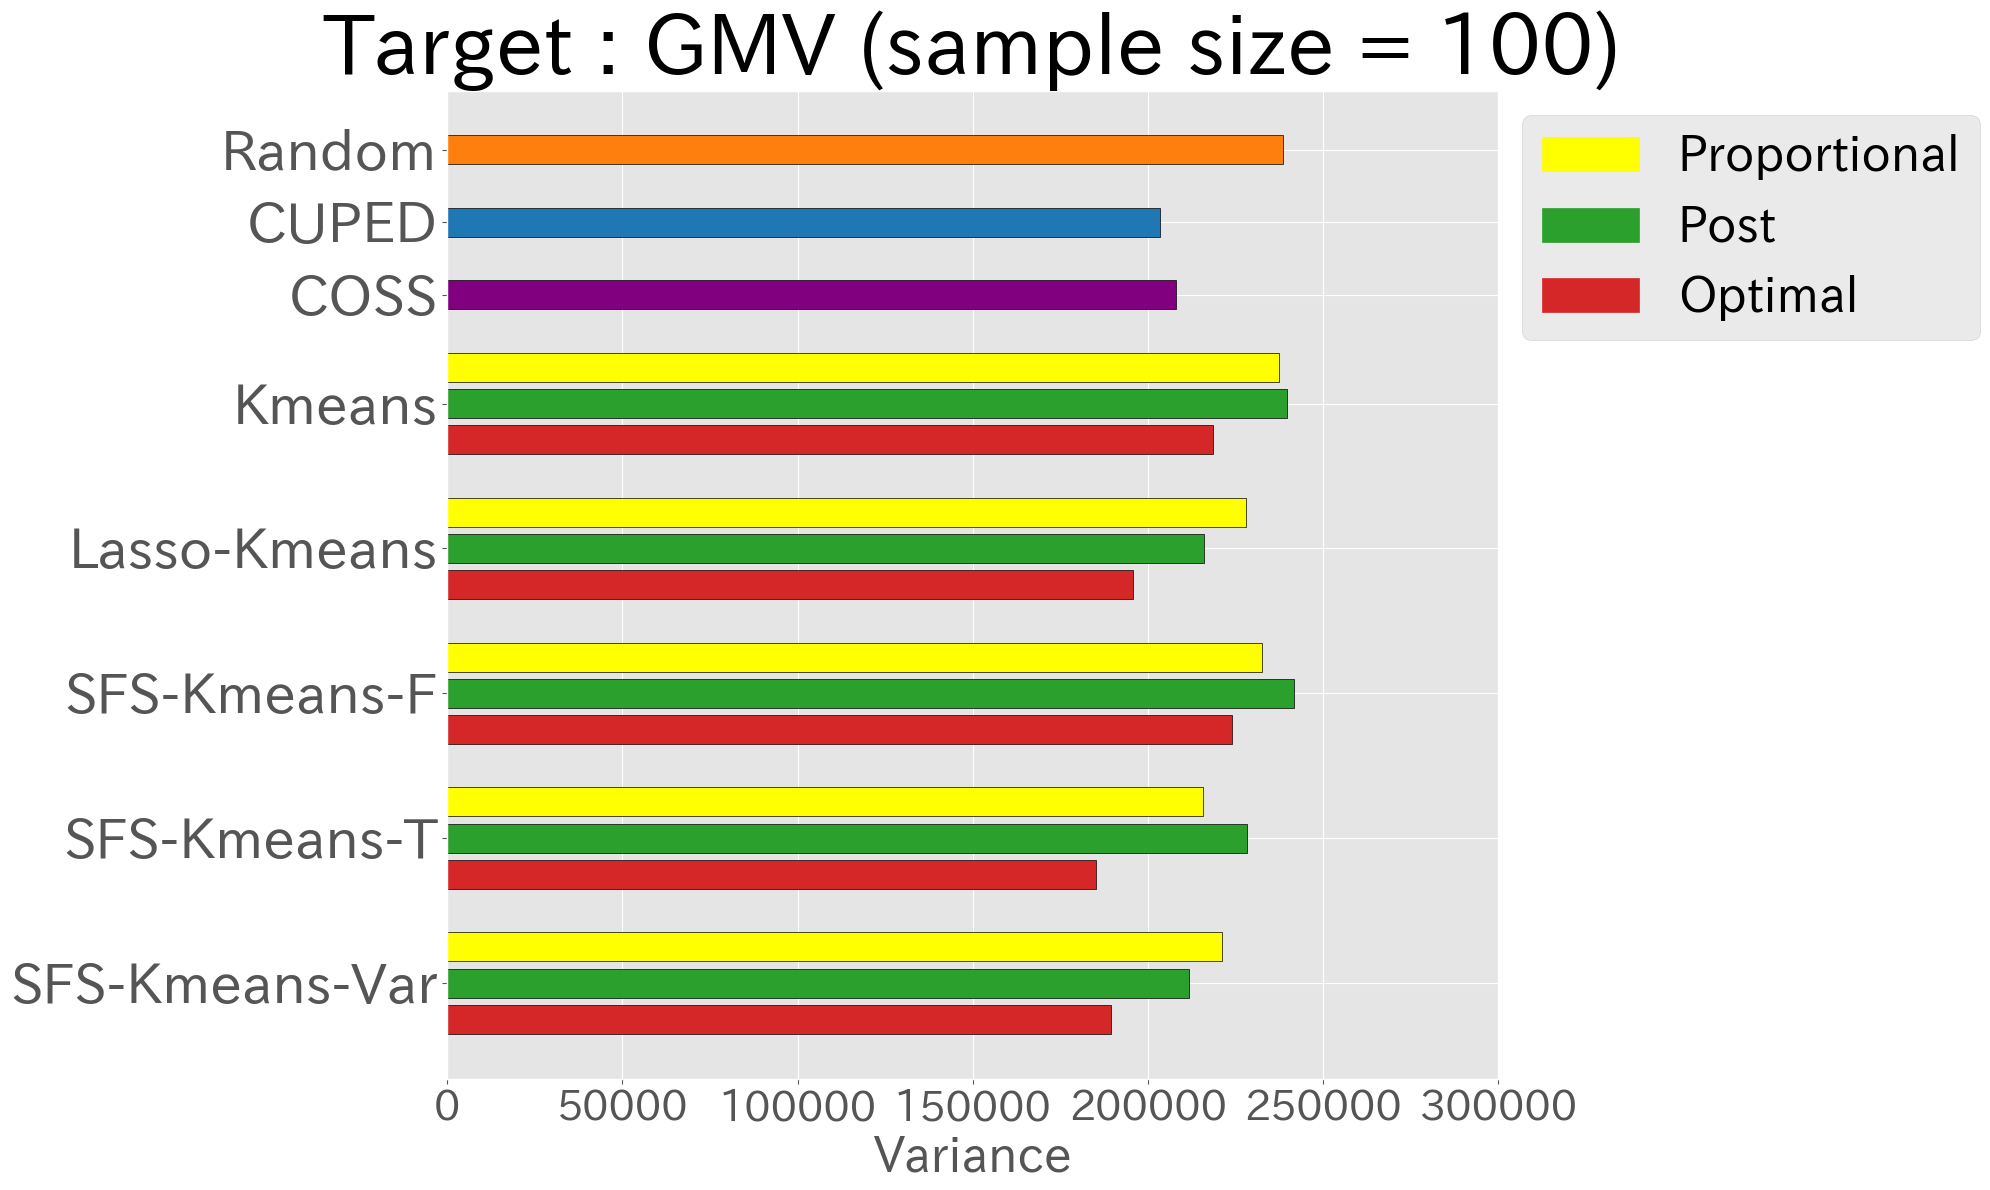

In [6]:
for var_dict in [var_dict_train, var_dict_test]:
    if var_dict == var_dict_train:
        print("訓練データの結果")
    if var_dict == var_dict_test:
        print("テストデータの結果")
    # グラフ用データを準備
    labels = [
        "SFS-Kmeans-Var",
        "SFS-Kmeans-T",
        "SFS-Kmeans-F",
        "Lasso-Kmeans",
        "Kmeans",
        "COSS",
        "CUPED",
        "Random",
    ]

    values = (
        list(var_dict["SFS-Kmeans-Var"].values())
        + [0]
        + list(var_dict["SFS-Kmeans-T"].values())
        + [0]
        + list(var_dict["SFS-Kmeans-F"].values())
        + [0]
        + list(var_dict["Lasso-Kmeans"].values())
        + [0]
        + list(var_dict["Kmeans"].values())
        + [0]
        + [var_dict["COSS"]]
        + [0]
        + [var_dict["CUPED"]]
        + [0]
        + [var_dict["Random"]]
    )

    # 各グループに色を割り当て、間隔には透明な色を使用
    colors = (
        ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#800080"]
        + ["#FFFFFF00"]
        + ["#1f77b4"]
        + ["#FFFFFF00"]
        + ["#ff7f0e"]
    )

    # 各ラベルが3つの棒の真ん中に配置されるように位置を調整
    y_positions = [1, 5, 9, 13, 17, 20, 22, 24]

    # グラフを描画
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.barh(range(len(values)), values, color=colors, edgecolor="black")

    # 凡例の追加
    legend_labels = ["Proportional", "Post", "Optimal"]
    # 色のリスト
    legend_colors = ["#FFFF00", "#2ca02c", "#d62728"]
    # 各ラベルに対してハンドルを作成
    handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in legend_colors]
    ax.legend(
        handles, legend_labels, fontsize=35, loc="upper left", bbox_to_anchor=(1, 1)
    )

    # y軸の目盛りとラベルを設定
    ax.set_yticks(y_positions)
    ax.tick_params(axis="x", labelsize=30)
    ax.set_yticklabels(labels, fontsize=40)
    ax.set_xlabel("Variance", fontsize=35)
    ax.set_title(f"Target : {TARGET} (sample size = {SAMPLE_SIZE})", fontsize=60)
    ax.set_xlim(0, X_LIM_MAX)
    plt.tight_layout()
    plt.show()

削減率

訓練データの結果


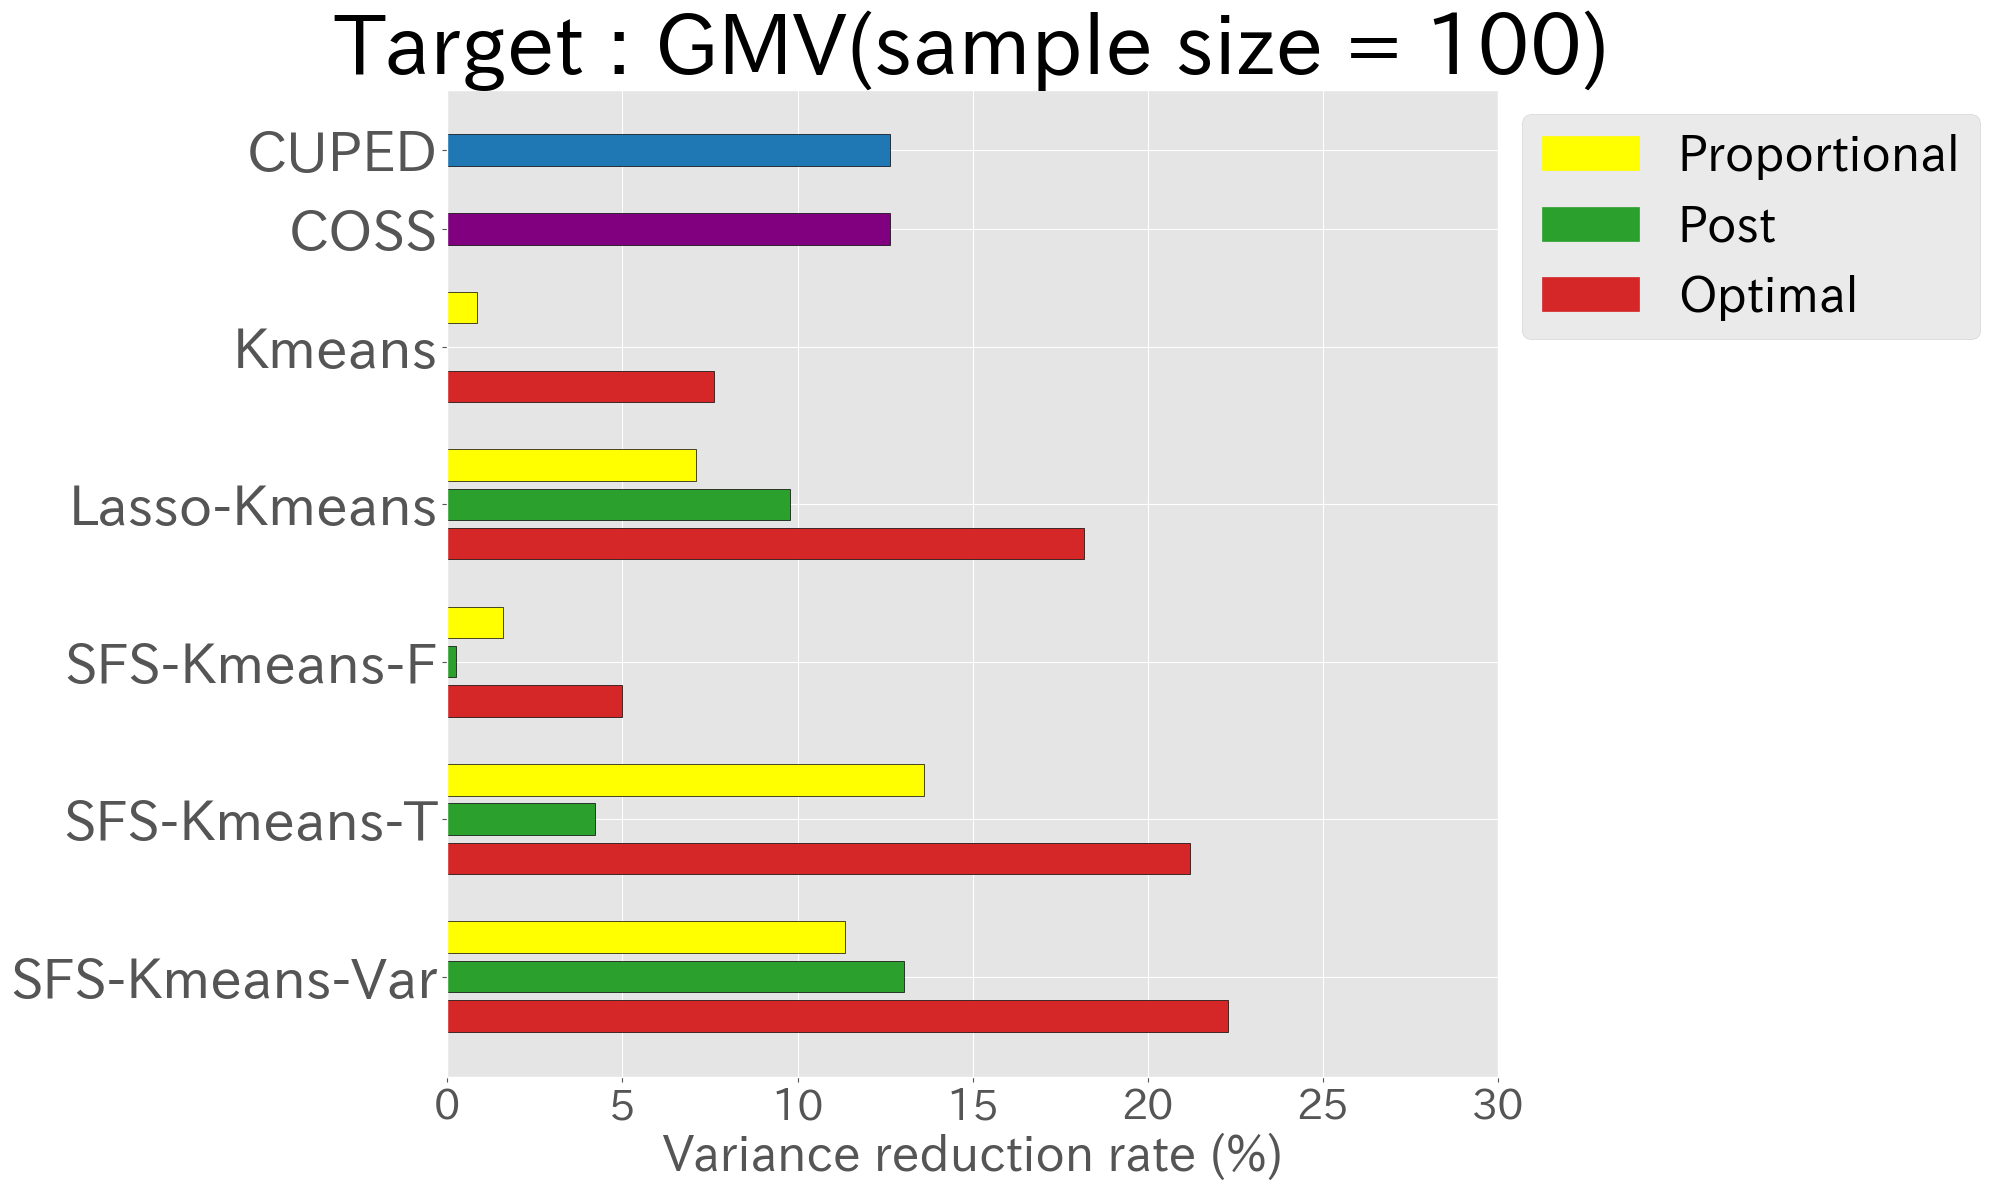

テストデータの結果


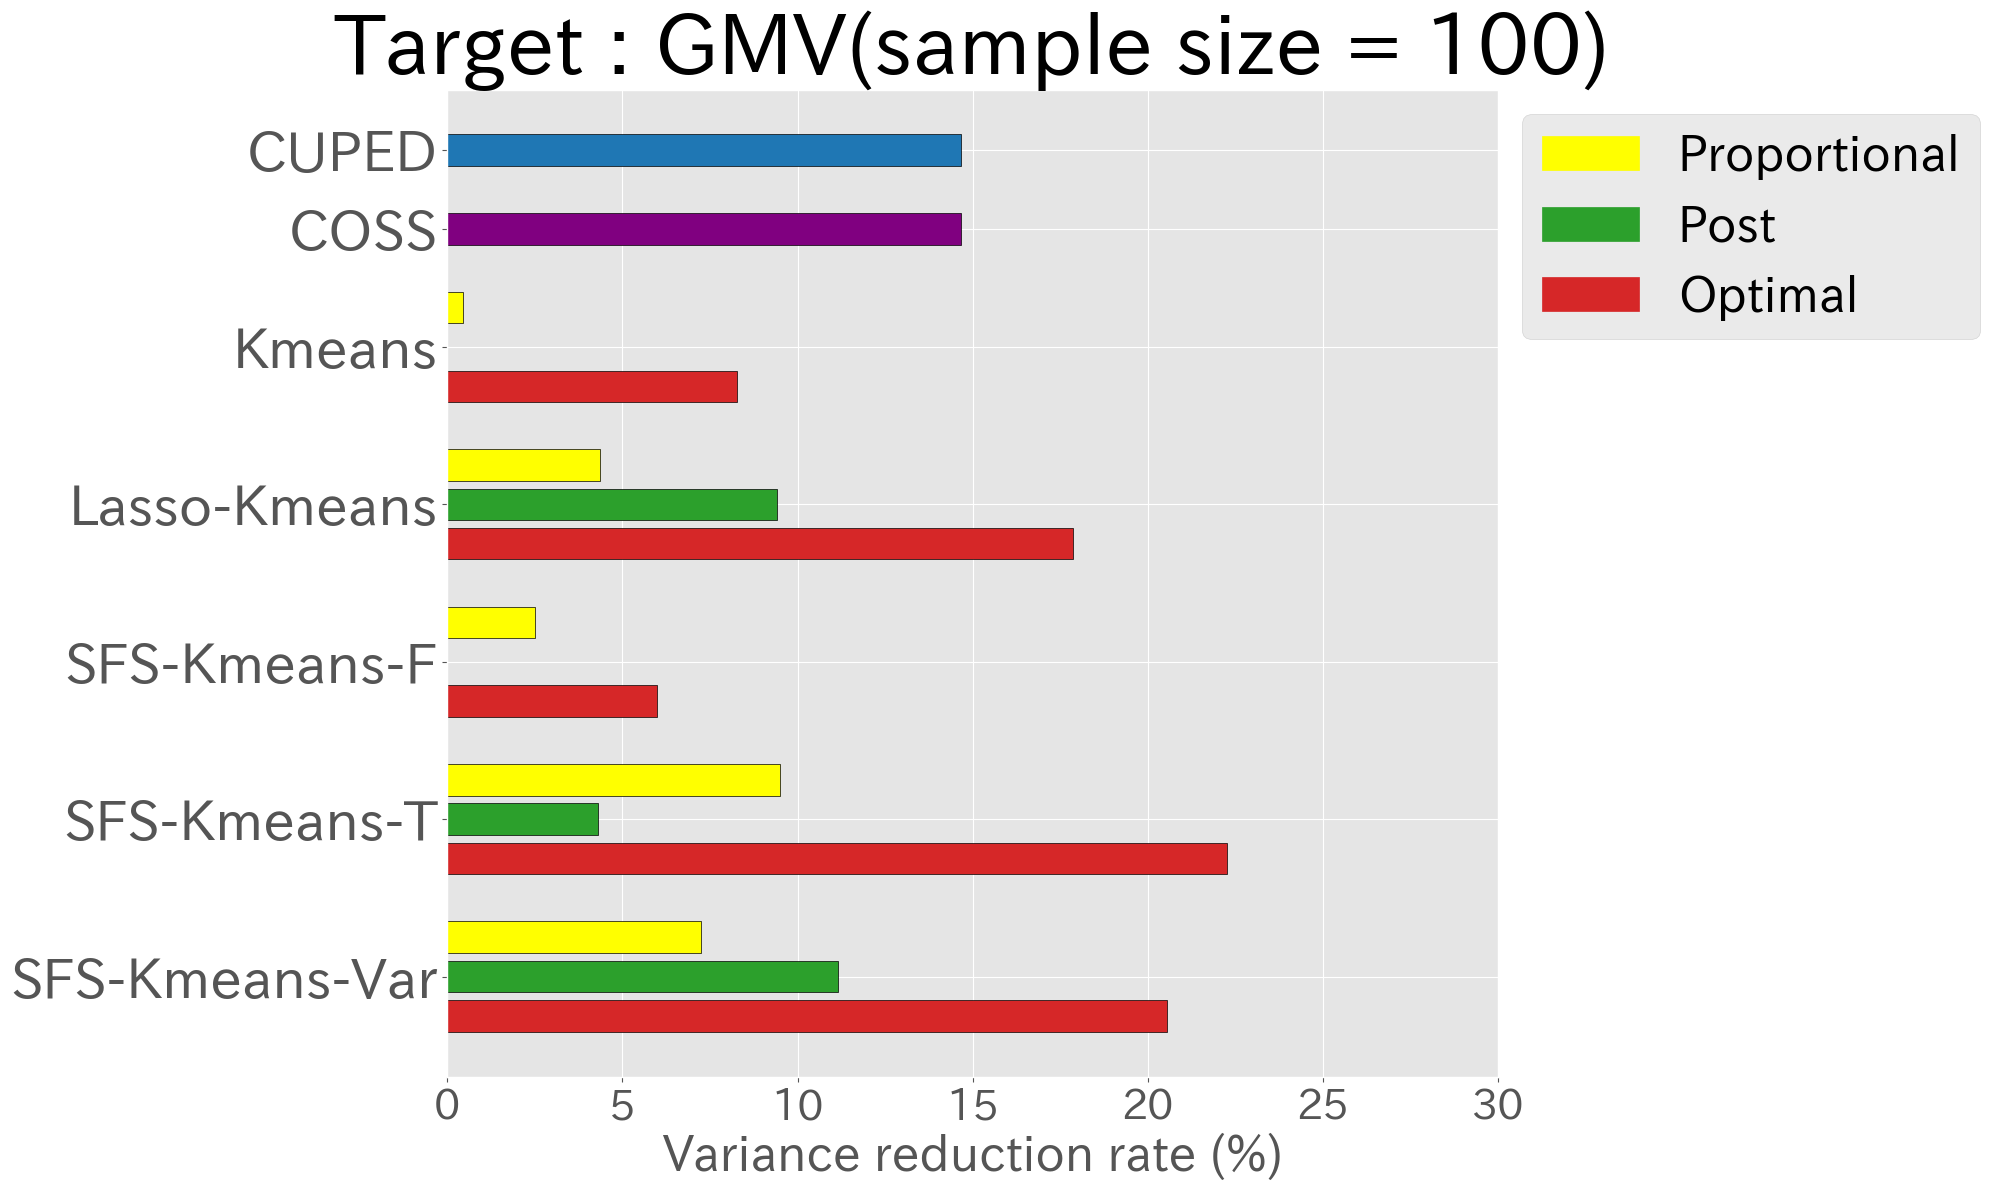

In [7]:
for reduc_dict in [reduc_dict_train, reduc_dict_test]:
    if reduc_dict == reduc_dict_train:
        print("訓練データの結果")
    if reduc_dict == reduc_dict_test:
        print("テストデータの結果")

    # グラフ用データを準備
    labels = [
        "SFS-Kmeans-Var",
        "SFS-Kmeans-T",
        "SFS-Kmeans-F",
        "Lasso-Kmeans",
        "Kmeans",
        "COSS",
        "CUPED",
    ]
    values = (
        list(reduc_dict["SFS-Kmeans-Var"].values())
        + [0]
        + list(reduc_dict["SFS-Kmeans-T"].values())
        + [0]
        + list(reduc_dict["SFS-Kmeans-F"].values())
        + [0]
        + list(reduc_dict["Lasso-Kmeans"].values())
        + [0]
        + list(reduc_dict["Kmeans"].values())
        + [0]
        + [reduc_dict["COSS"]]
        + [0]
        + [reduc_dict["CUPED"]]
    )

    # 各グループに色を割り当て、間隔には透明な色を使用
    colors = (
        ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#800080"]
        + ["#FFFFFF00"]
        + ["#1f77b4"]
    )

    # 各ラベルが3つの棒の真ん中に配置されるように位置を調整
    y_positions = [1, 5, 9, 13, 17, 20, 22]

    # グラフを描画
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.barh(range(len(values)), values, color=colors, edgecolor="black")

    # 凡例の追加
    legend_labels = ["Proportional", "Post", "Optimal"]
    # 色のリスト
    legend_colors = ["#FFFF00", "#2ca02c", "#d62728"]
    # 各ラベルに対してハンドルを作成
    handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in legend_colors]
    ax.legend(
        handles, legend_labels, fontsize=35, loc="upper left", bbox_to_anchor=(1, 1)
    )

    # y軸の目盛りとラベルを設定
    ax.set_yticks(y_positions)
    ax.tick_params(axis="x", labelsize=30)
    ax.set_yticklabels(labels, fontsize=40)
    ax.set_xlabel("Variance reduction rate (%)", fontsize=35)
    ax.set_title(f"Target : {TARGET}(sample size = {SAMPLE_SIZE})", fontsize=60)
    ax.set_xlim(0, 30)
    plt.tight_layout()
    plt.show()